# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras, matmul, reshape
from sklearn.metrics import roc_curve, auc
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, InputLayer
import csv
import sklearn.metrics as metrics
# from keras import regularizers
# import keras.backend as K
from tensorflow.math import exp
from keras.models import Model,load_model
from tensorflow.keras import layers,initializers
# from tensorflow.core.util import event_pb2
# from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir(r'/content/drive/My Drive/KD')

In [ ]:
df = pd.read_csv('./annotations.csv')
df_train = df[df["Partition"] == "train"]
df_test = df[df["Partition"] == "test"]

batch_size = 32
TRAIN_BATCHES=math.ceil(len(df_train)/batch_size )
TEST_BATCHES=math.ceil(len(df_test)/batch_size )


# Data loading

In [ ]:
#@title 
train_labels = []
test_labels = []
train_img = []
test_img = []

In [ ]:
#@title 
BATCH_SIZE=2
img_dir = 'images'
train_dir = 'images/train'
test_dir = 'images/test'
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)
#seperate in diff files    
# label HP with first one and SSA with second one   
if not os.path.isdir(os.path.join(train_dir, '01_HP')):
    os.mkdir(os.path.join(train_dir, '01_HP'))
if not os.path.isdir(os.path.join(train_dir, '02_SSA')):
    os.mkdir(os.path.join(train_dir, '02_SSA'))
if not os.path.isdir(os.path.join(test_dir, '01_HP')):
    os.mkdir(os.path.join(test_dir, '01_HP'))
if not os.path.isdir(os.path.join(test_dir, '02_SSA')):
    os.mkdir(os.path.join(test_dir, '02_SSA'))
  
anno_csv = 'annotations.csv'
with open(anno_csv, 'r') as csvfile:
    first_row = True
    for row in csv.reader(csvfile):
        if first_row:
            first_row = False
            continue
        if row[3] == 'train':
            train_img.append(row[0])
            if row[1] == 'HP':
                train_labels.append([1, 0])
            elif row[1] == 'SSA':
                train_labels.append([0, 1])
        elif row[3] == 'test':
            test_img.append(row[0])
            if row[1] == 'HP':
                test_labels.append([1, 0])
            elif row[1] == 'SSA':
                test_labels.append([0, 1])
        if row[0] in os.listdir(img_dir):
            if row[1] == 'HP' and row[3] == 'train':
                os.rename(os.path.join(img_dir, row[0]), os.path.join(train_dir, '01_HP', row[0]))
            elif row[1] == 'SSA' and row[3] == 'train':
                os.rename(os.path.join(img_dir, row[0]), os.path.join(train_dir, '02_SSA', row[0]))
            elif row[1] == 'HP' and row[3] == 'test':
                os.rename(os.path.join(img_dir, row[0]), os.path.join(test_dir, '01_HP', row[0]))
            elif row[1] == 'SSA' and row[3] == 'test':
                os.rename(os.path.join(img_dir, row[0]), os.path.join(test_dir, '02_SSA', row[0]))
    
# similar to project A
train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=(224, 224),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

eval_generator = test_datagen.flow_from_directory(test_dir,
                                                  class_mode='categorical',
                                                  interpolation='bilinear',
                                                  target_size=(224, 224),
                                                  batch_size=244,
                                                  shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  class_mode='categorical',
                                                  interpolation='bilinear',
                                                  target_size=(224, 224),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False)

Found 2175 images belonging to 2 classes.
Found 977 images belonging to 2 classes.
Found 977 images belonging to 2 classes.


# Model creation

In [ ]:
#@title models
#build teacher model
teacher_model = tf.keras.Sequential()
teacher_model.add(tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, pooling='avg', classifier_activation = None, input_shape = (224, 224, 3)))
teacher_model.add(tf.keras.layers.Dense(2)) 


# build student model
student_with_kd_model = tf.keras.Sequential()
student_with_kd_model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, pooling='avg',classifier_activation = None, input_shape = (224, 224, 3)))
student_with_kd_model.add(tf.keras.layers.Dense(2)) 

# student_with_kd_model = tf.keras.Sequential()
# student_with_kd_model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(classifier_activation = None, input_shape = (224, 224, 3)))
# student_with_kd_model.add(tf.keras.layers.Dense(2)) 

student_with_kd_model.save_weights('student_with_kd_model.h5')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
teacher_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_4 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
student_with_kd_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_5 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


# Loss functions

In [ ]:
#@title Teacher loss
def compute_teacher_loss(model, images, labels):
    class_logits = model(images, training=True)
    # Compute cross-entropy loss for classes.
    cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, class_logits)
    return cross_entropy_loss_value

In [ ]:
#@title student loss
BATCH_SIZE = 2
alpha = 0.5 # task balance between cross-entropy and distillation loss
temperature = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    # your code start from here for step 3
    soft_targets = teacher_logits / temperature

    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(student_model, images, labels):    
    student_class_logits = student_model(images, training=True)
    #soft target
    teacher_class_logits = teacher_model(images, training=False)
    distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, temperature)

    #hard target   
    cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits)
    return  alpha * cross_entropy_loss_value + (1 - alpha) * distillation_loss_value


# Train and evaluation

In [ ]:
#@title train and evaluation
@tf.function
def compute_num_correct(model, images, labels):
    class_logits = model(images, training=False)
    return tf.reduce_sum(
        tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

def train(model, compute_loss_fn, num_epochs, learning_rate):
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  train_generator.reset()   
  accuracy = 0   
  for epoch in range(1, num_epochs + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for batch in range(TRAIN_BATCHES):           
      images, labels = train_generator.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(model, images, labels)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables)) 

def evaluation(model, compute_loss_fn,learning_rate):
    eval_generator.reset()
    image_batch,label_batch=eval_generator.next()

    y_score = model.predict(image_batch)
    y_pred = np.argmax(y_score, axis=1)

    predicted_class=np.array([np.argmax(x) for x in y_score])
    labels=[np.where(label_batch[j]==1)[0][0] for j in range(len(label_batch))]
    precision, recall, f_1, _ = metrics.precision_recall_fscore_support(labels, predicted_class , average='micro')
    print("Precision: "+str(precision))
    print("Recall: " +str(recall))
    print("F-1: "+str(f_1))
    print()


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    l=["HP","SSA"]
    for j,i in zip(l,range(2)):
      fpr[i], tpr[i], _= roc_curve(label_batch[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      print("The AUC of class ", j," is "+str(roc_auc[i]))

    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
    for i, ax in zip(range(2), axs.ravel()):
      ax.plot(fpr[i],tpr[i],color='magenta',label= 'ROC curve (AUC = %0.4f)' % roc_auc[i]) 
      ax.plot([0, 1], [0, 1], 'b--')
      ax.set_xlim([0.0, 1.0])
      ax.set_ylim([0.0, 1.05])
      ax.set_xlabel("False Positive Rate")
      ax.set_ylabel("True Positive Rate")
      ax.set_title('ROC Curve for class '+ l[i]) 
      ax.legend(loc= "lower right")
      fig.tight_layout(pad=3.0)
    x=random.randint(1,100)
    plt.savefig('./ROC_Curve_'+str(learning_rate)+'_'+str(x)+'_.png')
    return f_1

def train_and_evaluate(model, compute_loss_fn, learning_rate):
  #train
  train(model, compute_loss_fn, 10, learning_rate)
  reduced_learning_rate=learning_rate/(10.0)
  train(model, compute_loss_fn, 25, reduced_learning_rate)

  # Run evaluate the last epochs
  evaluation(model, compute_loss_fn, learning_rate)

# Training models

In [ ]:
# Train teacher model
train_and_evaluate(teacher_model, compute_teacher_loss,1e-4)
teacher_model.save('./KD2/teacher_task2.h5')

# Train student model
train_and_evaluate(student_with_kd_model, compute_student_loss, 1e-3)
student_with_kd_model.save('./KD2/KD2/task2_student.h5')

Precision: 0.8278688524590164
Recall: 0.8278688524590164
F-1: 0.8278688524590164

The AUC of class  HP  is 0.9063829787234042
The AUC of class  SSA  is 0.9099999999999999


<Figure size 432x288 with 0 Axes>

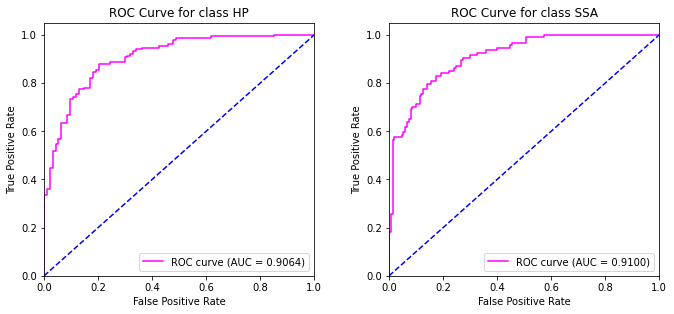

In [ ]:
teacher_model=load_model('./KD2/teacher_task2.h5')
evaluation(teacher_model, compute_teacher_loss,1e-4)

Precision: 0.7868852459016393
Recall: 0.7868852459016393
F-1: 0.7868852459016392

The AUC of class  HP  is 0.8854821617802897
The AUC of class  SSA  is 0.8738961497703992


<Figure size 432x288 with 0 Axes>

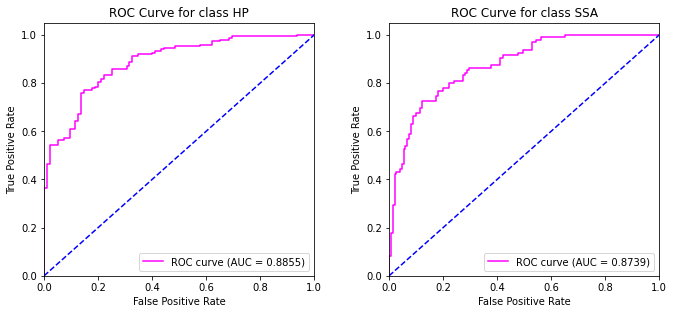

In [ ]:
student_model=load_model('./KD2/task2_student.h5')
evaluation(student_model,compute_student_loss,1e-3)



-------- with alpha of  0.5 ------------
Precision: 0.6598360655737705
Recall: 0.6598360655737705
F-1: 0.6598360655737705

The AUC of class  HP  is 0.7609069819651275
The AUC of class  SSA  is 0.7627029858564693
Precision: 0.6188524590163934
Recall: 0.6188524590163934
F-1: 0.6188524590163934

The AUC of class  HP  is 0.7526525671152887
The AUC of class  SSA  is 0.750623086235135
Precision: 0.5983606557377049
Recall: 0.5983606557377049
F-1: 0.5983606557377049

The AUC of class  HP  is 0.8002166620072686
The AUC of class  SSA  is 0.8002166620072686
Precision: 0.6557377049180327
Recall: 0.6557377049180327
F-1: 0.6557377049180327

The AUC of class  HP  is 0.7478422619047619
The AUC of class  SSA  is 0.7478422619047619
Precision: 0.680327868852459
Recall: 0.680327868852459
F-1: 0.680327868852459

The AUC of class  HP  is 0.819470188446092
The AUC of class  SSA  is 0.817462156317578
Precision: 0.6229508196721312
Recall: 0.6229508196721312
F-1: 0.6229508196721312

The AUC of class  HP  is 0

<Figure size 432x288 with 0 Axes>

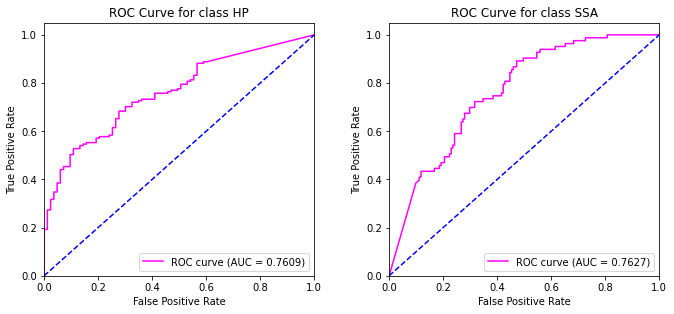

<Figure size 432x288 with 0 Axes>

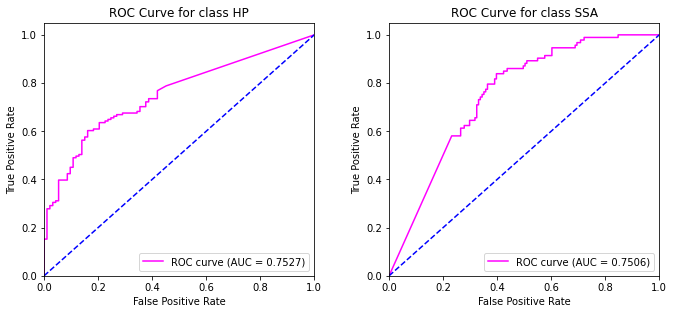

<Figure size 432x288 with 0 Axes>

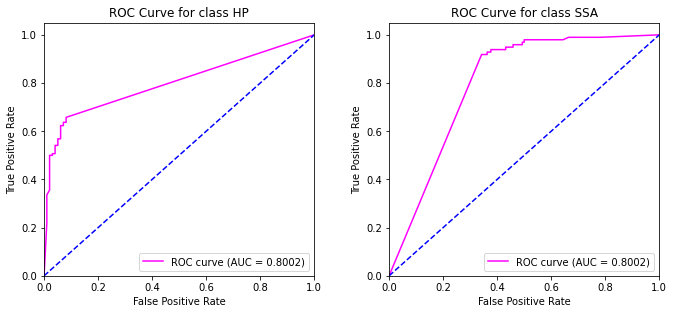

<Figure size 432x288 with 0 Axes>

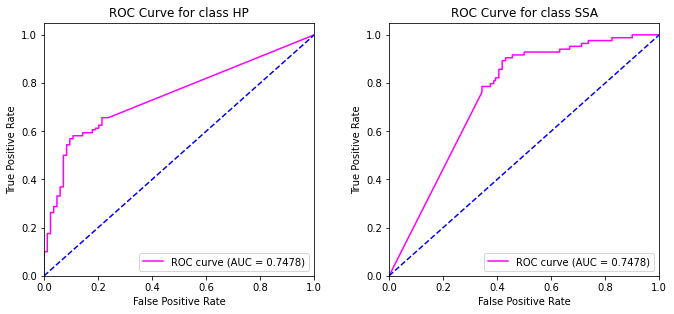

<Figure size 432x288 with 0 Axes>

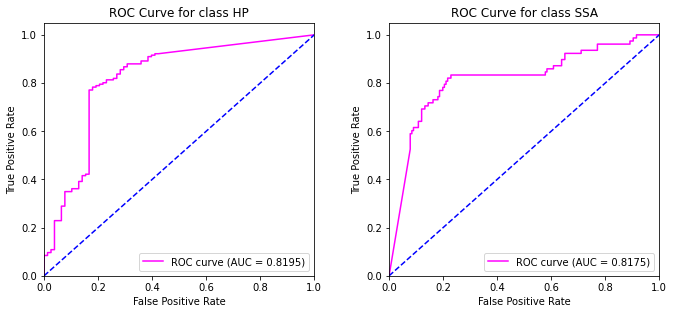

<Figure size 432x288 with 0 Axes>

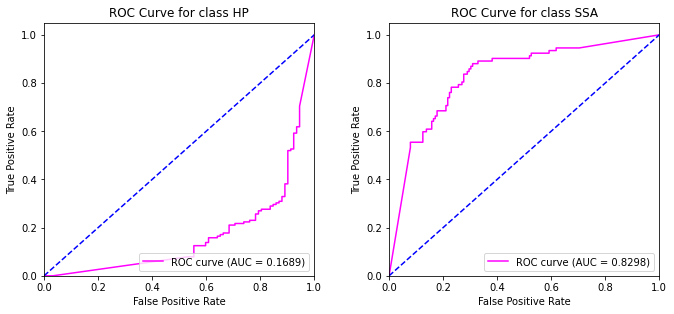

In [ ]:
# temperature
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
_f1_student=[]

# for ALPHA in ALPHA_spectrum:
ALPHA=0.5 
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:  
  # student_with_kd_model = tf.keras.Sequential()
  # student_with_kd_model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(classifier_activation = None, input_shape = (224, 224, 3)))
  # student_with_kd_model.add(tf.keras.layers.Dense(2)) 
  # f1_student = train_and_evaluate(student_with_kd_model, compute_student_loss)
  #student_with_kd_model.save("./KD2/student_model_with_kd_"+str(DISTILLATION_TEMPERATURE)+'_.h5')
  student_model=load_model("./KD2/student_model_with_kd_"+str(DISTILLATION_TEMPERATURE)+'_.h5')
  f1_student =evaluation(student_model,compute_student_loss,1e-3)
  _f1_student.append(f1_student)



-------- with alpha of  0.5 ------------
Precision: 0.6639344262295082
Recall: 0.6639344262295082
F-1: 0.6639344262295082

The AUC of class  HP  is 0.7460478771454382
The AUC of class  SSA  is 0.7457844022884673
Precision: 0.6434426229508197
Recall: 0.6434426229508197
F-1: 0.6434426229508197

The AUC of class  HP  is 0.7211362471630427
The AUC of class  SSA  is 0.7219049710813383
Precision: 0.680327868852459
Recall: 0.680327868852459
F-1: 0.680327868852459

The AUC of class  HP  is 0.7843682421995676
The AUC of class  SSA  is 0.7843682421995675
Precision: 0.5901639344262295
Recall: 0.5901639344262295
F-1: 0.5901639344262295

The AUC of class  HP  is 0.8077777777777778
The AUC of class  SSA  is 0.8077777777777778
Precision: 0.6311475409836066
Recall: 0.6311475409836066
F-1: 0.6311475409836066

The AUC of class  HP  is 0.7889610389610389
The AUC of class  SSA  is 0.7863636363636363
Precision: 0.6352459016393442
Recall: 0.6352459016393442
F-1: 0.6352459016393442

The AUC of class  HP  i

<Figure size 432x288 with 0 Axes>

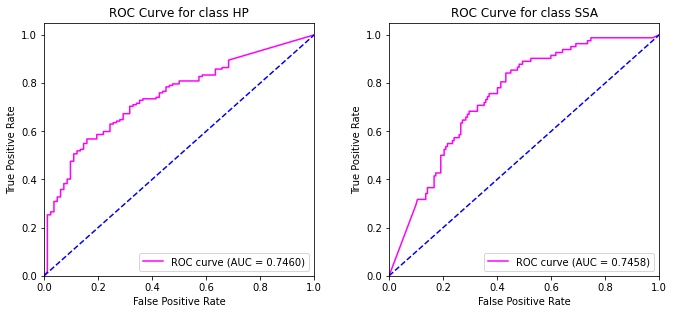

<Figure size 432x288 with 0 Axes>

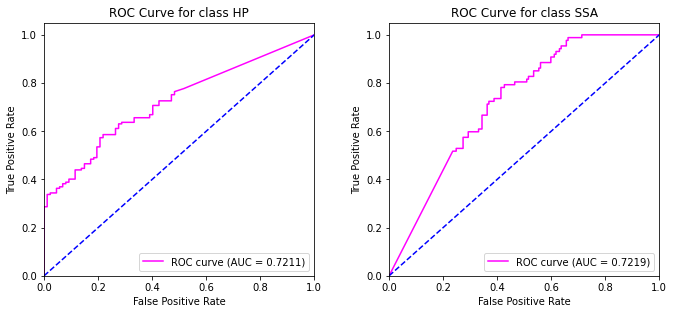

<Figure size 432x288 with 0 Axes>

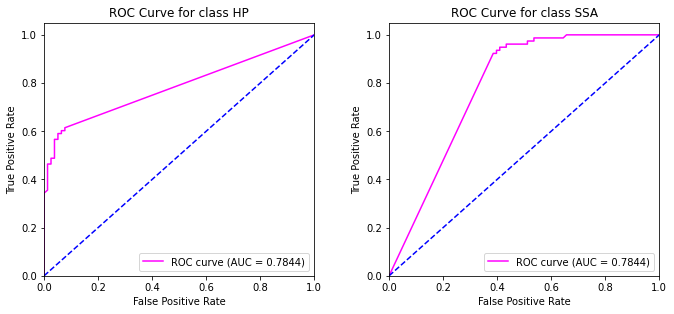

<Figure size 432x288 with 0 Axes>

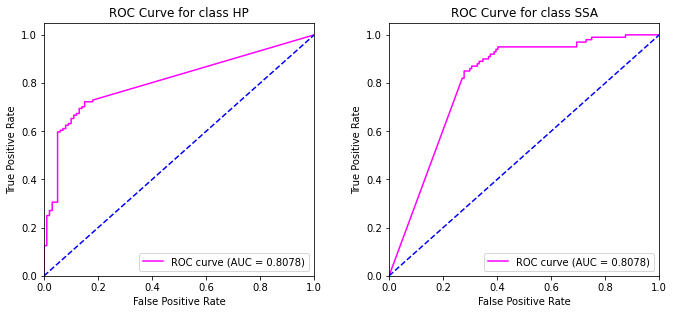

<Figure size 432x288 with 0 Axes>

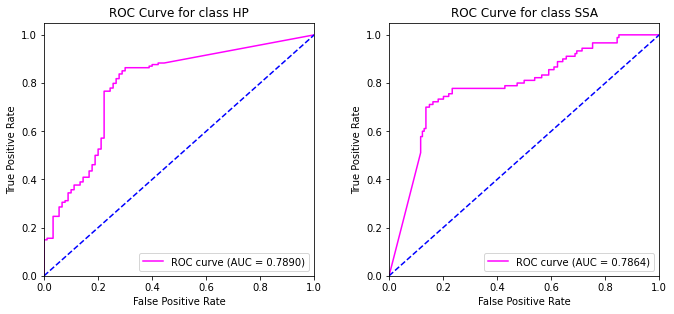

<Figure size 432x288 with 0 Axes>

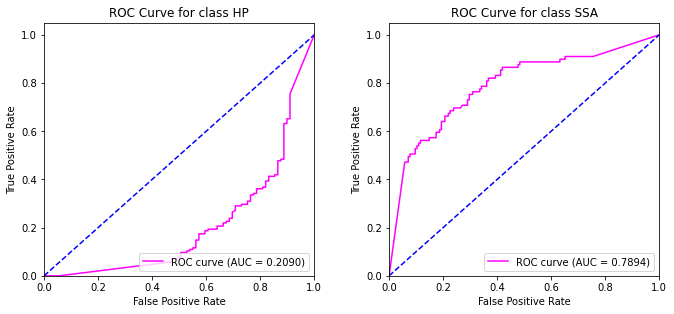

In [ ]:
# temperature
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
_f1_student=[]

# for ALPHA in ALPHA_spectrum:
ALPHA=0.5 
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:  
  # student_with_kd_model = tf.keras.Sequential()
  # student_with_kd_model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(classifier_activation = None, input_shape = (224, 224, 3)))
  # student_with_kd_model.add(tf.keras.layers.Dense(2)) 
  # f1_student = train_and_evaluate(student_with_kd_model, compute_student_loss)
  #student_with_kd_model.save("./KD2/student_model_with_kd_"+str(DISTILLATION_TEMPERATURE)+'_.h5')
  student_model=load_model("./KD2/student_model_with_kd_"+str(DISTILLATION_TEMPERATURE)+'_.h5')
  f1_student =evaluation(student_model,compute_student_loss,1e-3)
  _f1_student.append(f1_student)

In [ ]:
_f1_student

[0.6598360655737705,
 0.6188524590163934,
 0.5983606557377049,
 0.6557377049180327,
 0.680327868852459,
 0.6229508196721312]

# Test accuracy vs. tempreture curve

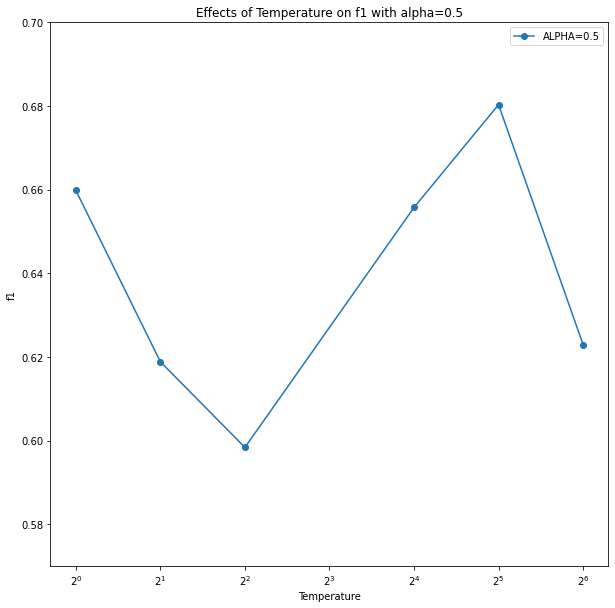

<Figure size 432x288 with 0 Axes>

In [ ]:
# visualization
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale('log',basex=2)
ax.plot(DISTILLATION_TEMPERATURE_spectrum, _f1_student, marker='o', label='ALPHA=0.5')

plt.ylim(0.57,0.70)
plt.ylabel('f1')
plt.xlabel('Temperature')
plt.title('Effects of Temperature on f1 with alpha=0.5')
plt.legend()
plt.show()
plt.savefig('task2_temp_f1.png')

# Train student from scratch

In [ ]:
#build model
student_scratch_model = tf.keras.Sequential()
student_scratch_model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, pooling='avg',classifier_activation = None, input_shape = (224, 224, 3)))
student_scratch_model.add(tf.keras.layers.Dense(2)) 

def compute_student_scratch_loss(model, images, labels, **kwargs):
    class_logits = model(images, training=True)
    # Compute cross-entropy loss for classes.    
    cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, class_logits/temperature) * temperature ** 2
    return cross_entropy_loss_value

Precision: 0.610655737704918
Recall: 0.610655737704918
F-1: 0.610655737704918

The AUC of class  HP  is 0.7669374779229954
The AUC of class  SSA  is 0.7658777817025786


0.610655737704918

<Figure size 432x288 with 0 Axes>

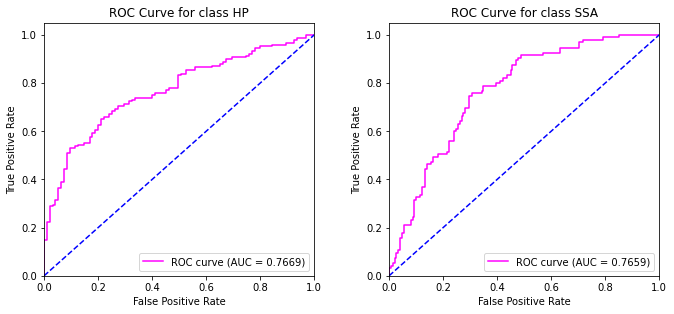

In [ ]:
# train_and_evaluate(student_scratch_model, compute_student_scratch_loss, 1e-3)
# student_scratch_model.save('./KD2/student_scratch_no_distillation.h5')

student_model_no_distill=load_model('./KD2/student_scratch_no_distillation.h5')
evaluation(student_model_no_distill,compute_student_scratch_loss,1e-3)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
!pip install keras-flops

In [ ]:
from keras_flops import get_flops

In [ ]:
# your code start from here for step 8
teacher_model=load_model('./KD2/teacher_task2.h5')
teacher_model.summary()
teacher_model_flops=get_flops(teacher_model, batch_size=1)
print('\n')
print(f'Student model with KD FLOPs: {teacher_model_flops/10**9}')


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_10 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________


Student model with KD FLOPs: 6.988381826


In [ ]:
student_with_kd_model=load_model('./KD2/task2_student.h5')
student_with_kd_model.summary()
student_with_kd_model_flops=get_flops(student_with_kd_model, batch_size=1)
print('\n')
print(f'Student model with KD FLOPs: {student_with_kd_model_flops/10**9}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


Student model with KD FLOPs: 0.61273133


In [ ]:
student_model_no_distill=load_model('./KD2/student_scratch_no_distillation.h5')
student_model_no_distill.summary()
student_model_no_distill_flops=get_flops(student_model_no_distill, batch_size=1)
print('\n')
print(f'Student model without KD FLOPs: {student_model_no_distill_flops/10**9}')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_12 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


Student model without KD FLOPs: 0.61273133


# XAI method to explain models

In [ ]:
#@title
teacher_model=load_model('./KD2/teacher_task2.h5')
student_with_kd_model=load_model('./KD2/task2_student.h5')
student_model_no_distill=load_model('./KD2/student_scratch_no_distillation.h5')

In [ ]:
#@title
eval_generator = test_datagen.flow_from_directory(test_dir,
                                                  class_mode='categorical',
                                                  interpolation='bilinear',
                                                  target_size=(224, 224),
                                                  batch_size=10,
                                                  shuffle=True)

Found 977 images belonging to 2 classes.


In [ ]:
#@title Integrated gradient
# your code start from here for step 9
def _gradients_(input, model, pred_index):
  images = tf.convert_to_tensor(input,dtype='float32')

  with tf.GradientTape() as tape:
    tape.watch(images)
    preds=model(images)
    grads = tape.gradient(preds[:, pred_index],images)
  return grads

def IG_(input, model, label, knots=3):
  steps = np.linspace(0.,1.,knots+1)[1:]
  interpolated_image = np.empty((knots,224,224,3))

  for i in range(knots):
    interpolated_image[i] = input * steps[i]
  
  grads = _gradients_(interpolated_image, model, label)
  ave_grad = tf.math.reduce_mean(grads,axis=0) 
  ave_grad = input * ave_grad
  return ave_grad


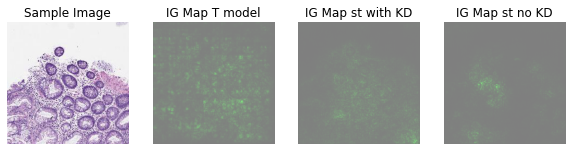

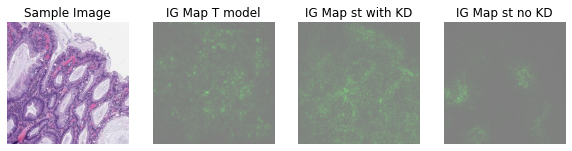

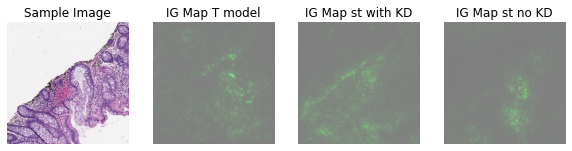

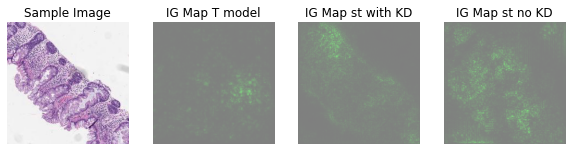

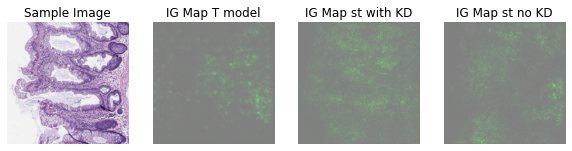

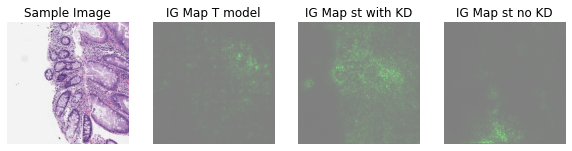

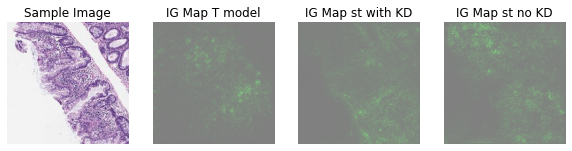

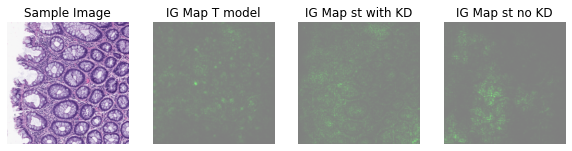

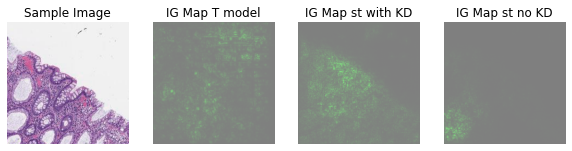

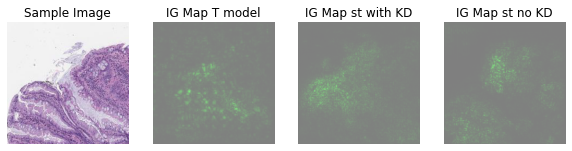

<Figure size 432x288 with 0 Axes>

In [ ]:
#visualization

def Explanation_Map_IG(ex_mp):
  em = np.expand_dims(np.average(abs(ex_mp),axis=2),2)* [0, 255, 0]
  em -= em.min()
  em /= em.max()+10e-30
  return em

eval_generator.reset()
image_batch,label_batch=eval_generator.next()
labels=[np.where(label_batch[j]==1)[0][0] for j in range(len(label_batch))]
for i in range(10):
  sample=image_batch[i]
  sample_labels = labels[i]


  IG_t = IG_(sample,teacher_model,sample_labels)
  IG_withKD_student = IG_(sample,student_with_kd_model,sample_labels)
  IG_student_no_distillation = IG_(sample,student_model_no_distill,sample_labels)

  plt.figure(figsize=(10,5))
  plt.subplot(1,4,1)
  plt.imshow(sample)
  plt.axis('off')
  plt.title('Sample Image')

  plt.subplot(1,4,2)
  explanation_map_Intgrad_t=Explanation_Map_IG(IG_t) 
  plt.imshow(explanation_map_Intgrad_t, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('IG Map T model')

  plt.subplot(1,4,3)
  explanation_map_Intgrad_st_kd=Explanation_Map_IG(IG_withKD_student)
  plt.imshow(explanation_map_Intgrad_st_kd, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('IG Map st with KD')

  plt.subplot(1,4,4)
  explanation_map_Intgrad_st_nokd=Explanation_Map_IG(IG_student_no_distillation)
  plt.imshow(explanation_map_Intgrad_st_nokd, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('IG Map st no KD')
  plt.show()

plt.savefig('XAI method_task2_.png')

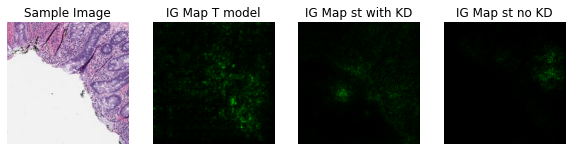

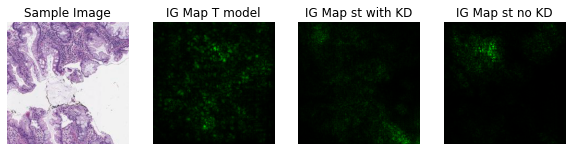

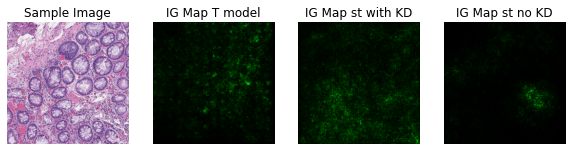

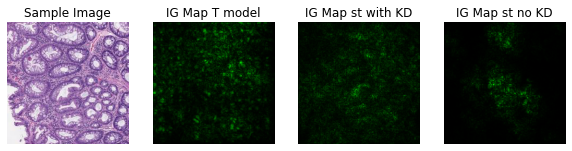

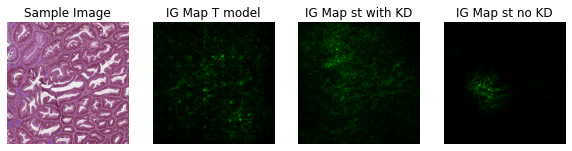

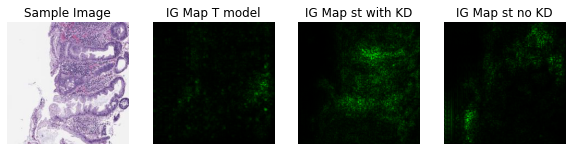

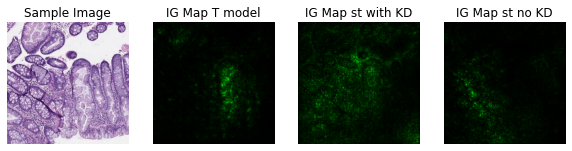

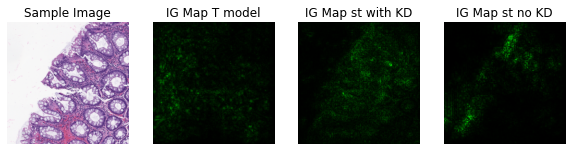

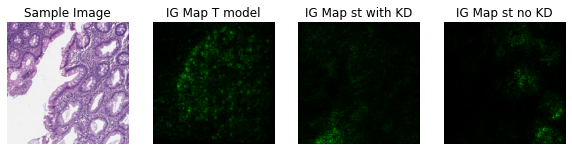

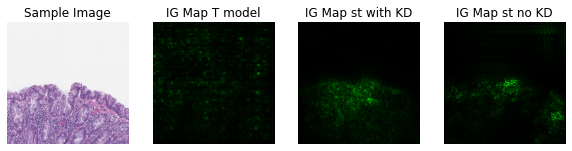

<Figure size 432x288 with 0 Axes>

In [ ]:
#visualization

def Explanation_Map_IG(ex_mp):
  em = np.expand_dims(np.average(abs(ex_mp),axis=2),2)* [0, 255, 0]
  em -= em.min()
  em /= em.max()+10e-30
  return em

eval_generator.reset()
image_batch,label_batch=eval_generator.next()
labels=[np.where(label_batch[j]==1)[0][0] for j in range(len(label_batch))]
for i in range(10):
  sample=image_batch[i]
  sample_labels = labels[i]


  IG_t = IG_(sample,teacher_model,sample_labels)
  IG_withKD_student = IG_(sample,student_with_kd_model,sample_labels)
  IG_student_no_distillation = IG_(sample,student_model_no_distill,sample_labels)

  plt.figure(figsize=(10,5))
  plt.subplot(1,4,1)
  plt.imshow(sample)
  plt.axis('off')
  plt.title('Sample Image')

  plt.subplot(1,4,2)
  explanation_map_Intgrad_t=Explanation_Map_IG(IG_t) 
  plt.imshow(explanation_map_Intgrad_t)
  plt.axis('off')
  plt.title('IG Map T model')

  plt.subplot(1,4,3)
  explanation_map_Intgrad_st_kd=Explanation_Map_IG(IG_withKD_student)
  plt.imshow(explanation_map_Intgrad_st_kd)
  plt.axis('off')
  plt.title('IG Map st with KD')

  plt.subplot(1,4,4)
  explanation_map_Intgrad_st_nokd=Explanation_Map_IG(IG_student_no_distillation)
  plt.imshow(explanation_map_Intgrad_st_nokd)
  plt.axis('off')
  plt.title('IG Map st no KD')
  plt.show()

plt.savefig('XAI method_task2.png')

# Implementing the state-of-the-art KD algorithm

In [ ]:
# #subclass distillation
# #Rafael M ̈uller, Simon Kornblith, and Geoffrey Hinton. Subclass distillation. arXiv preprint
# arXiv:2002.03936, 2020. https://arxiv.org/abs/2002.03936.

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

NUM_EPOCHS = 25
NUM_CLASSES = 2
NUM_SUBCLASSES = 8

ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 2.
BETA = 1.0
AUXILIARY_TEMPERATURE = 1.0

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras, matmul, reshape
from sklearn.metrics import roc_curve, auc
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, InputLayer
import csv
import sklearn.metrics as metrics
# from keras import regularizers
# import keras.backend as K
from tensorflow.math import exp
from keras.models import Model,load_model
from tensorflow.keras import layers,initializers
# from tensorflow.core.util import event_pb2
# from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir(r'/content/drive/My Drive/KD')

In [ ]:
df = pd.read_csv('./annotations.csv')
df_train = df[df["Partition"] == "train"]
df_test = df[df["Partition"] == "test"]

batch_size = 32
TRAIN_BATCHES=math.ceil(len(df_train)/batch_size )
TEST_BATCHES=math.ceil(len(df_test)/batch_size )

In [ ]:
#@title Data Loading
train_labels = []
test_labels = []
train_img = []
test_img = []

In [ ]:
#@title 
BATCH_SIZE=2
img_dir = 'images'
train_dir = 'images/train'
test_dir = 'images/test'
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)
#seperate in diff files    
# label HP with first one and SSA with second one   
if not os.path.isdir(os.path.join(train_dir, '01_HP')):
    os.mkdir(os.path.join(train_dir, '01_HP'))
if not os.path.isdir(os.path.join(train_dir, '02_SSA')):
    os.mkdir(os.path.join(train_dir, '02_SSA'))
if not os.path.isdir(os.path.join(test_dir, '01_HP')):
    os.mkdir(os.path.join(test_dir, '01_HP'))
if not os.path.isdir(os.path.join(test_dir, '02_SSA')):
    os.mkdir(os.path.join(test_dir, '02_SSA'))
  
anno_csv = 'annotations.csv'
with open(anno_csv, 'r') as csvfile:
    first_row = True
    for row in csv.reader(csvfile):
        if first_row:
            first_row = False
            continue
        if row[3] == 'train':
            train_img.append(row[0])
            if row[1] == 'HP':
                train_labels.append([1, 0])
            elif row[1] == 'SSA':
                train_labels.append([0, 1])
        elif row[3] == 'test':
            test_img.append(row[0])
            if row[1] == 'HP':
                test_labels.append([1, 0])
            elif row[1] == 'SSA':
                test_labels.append([0, 1])
        if row[0] in os.listdir(img_dir):
            if row[1] == 'HP' and row[3] == 'train':
                os.rename(os.path.join(img_dir, row[0]), os.path.join(train_dir, '01_HP', row[0]))
            elif row[1] == 'SSA' and row[3] == 'train':
                os.rename(os.path.join(img_dir, row[0]), os.path.join(train_dir, '02_SSA', row[0]))
            elif row[1] == 'HP' and row[3] == 'test':
                os.rename(os.path.join(img_dir, row[0]), os.path.join(test_dir, '01_HP', row[0]))
            elif row[1] == 'SSA' and row[3] == 'test':
                os.rename(os.path.join(img_dir, row[0]), os.path.join(test_dir, '02_SSA', row[0]))
    
# similar to project A
train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=(224, 224),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

eval_generator = test_datagen.flow_from_directory(test_dir,
                                                  class_mode='categorical',
                                                  interpolation='bilinear',
                                                  target_size=(224, 224),
                                                  batch_size=244,
                                                  shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  class_mode='categorical',
                                                  interpolation='bilinear',
                                                  target_size=(224, 224),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False)

Found 2175 images belonging to 2 classes.
Found 977 images belonging to 2 classes.
Found 977 images belonging to 2 classes.


In [ ]:
#@title Models for subclass distillation
#build teacher model
teacher_model = tf.keras.Sequential()
teacher_model.add(tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, pooling='avg', classifier_activation = None, input_shape = (224, 224, 3)))
#teacher_model.add(Flatten())
teacher_model.add(tf.keras.layers.Dense(8)) 


# build student model
student_model = tf.keras.Sequential()
student_model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, pooling='avg',classifier_activation = None, input_shape = (224, 224, 3)))
#student_model.add(Flatten())
student_model.add(tf.keras.layers.Dense(8)) 

# student_model = tf.keras.Sequential()
# student_model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(classifier_activation = None, input_shape = (224, 224, 3)))
#student_model.add(Flatten())
# student_model.add(tf.keras.layers.Dense(8)) 

student_model.save_weights('student_model.h5')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#@title #Teacher Loss Function

def auxiliary_loss(subclass_logits: tf.Tensor, temperature: Union[float, tf.Tensor]):
  temperature = tf.convert_to_tensor(temperature, dtype=subclass_logits.dtype)
  mean, var = tf.nn.moments(subclass_logits, -1, keepdims=True)
  num_subclasses = tf.convert_to_tensor(NUM_SUBCLASSES / NUM_CLASSES, dtype=subclass_logits.dtype)

  epsilon = tf.convert_to_tensor(1e-9, dtype=subclass_logits.dtype)

  vi = tf.nn.batch_normalization(subclass_logits, mean=mean, variance=var, offset=None, scale=1./ tf.sqrt(temperature * num_subclasses), variance_epsilon=epsilon)
  n = tf.cast(32, subclass_logits.dtype)

  products = tf.linalg.matmul(vi, vi, transpose_b=True)
  return (tf.math.reduce_mean(tf.math.reduce_logsumexp(products, -1)) - 1/temperature -tf.math.log(n))

def compute_teacher_loss_sub(model,images, labels):

  subclass_logits = model(images, training=True)

  # cross entropy 
  subclass_logits = tf.reshape(subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, class_logits)

  auxiliary_loss_value = auxiliary_loss(subclass_logits, AUXILIARY_TEMPERATURE)

  return cross_entropy_loss_value + BETA * auxiliary_loss_value

In [ ]:
#@title #Student Loss Function
BATCH_SIZE = 2
alpha = 0.5 # task balance between cross-entropy and distillation loss
temperature = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    soft_targets = teacher_logits / temperature
    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss_sub(student_model, images, labels):    
    student_subclass_logits = student_model(images, training=True)
    #soft target
    teacher_subclass_logits = teacher_model(images, training=False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, temperature)

    subclass_logits = tf.reshape(student_subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
    class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)

    #hard target   
    cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels,class_logits)
    return  alpha * cross_entropy_loss_value + (1.0 - alpha) * distillation_loss_value


In [ ]:
#@title train and evaluation
@tf.function
def compute_num_correct(model, images, labels):

  subclass_logits = model(images, training=False)
  subclass_logits = tf.reshape(subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)

  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train(model, compute_loss_fn, num_epochs, learning_rate):
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  train_generator.reset()   
  accuracy = 0   
  for epoch in range(1, num_epochs + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for batch in range(TRAIN_BATCHES):           
      images, labels = train_generator.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(model, images, labels)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables)) 

def evaluation(model, compute_loss_fn,learning_rate):
  
  eval_generator.reset()
  image_batch,label_batch=eval_generator.next()

  subclass_logits = model(image_batch, training=False)
  subclass_logits = tf.reshape(subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)
  labels=tf.argmax(label_batch,-1)
  predicted_class= tf.argmax(class_logits, -1)
  precision, recall, f_1, _ = metrics.precision_recall_fscore_support(labels, predicted_class , average='micro')
  print("Precision: "+str(precision))
  print("Recall: " +str(recall))
  print("F-1: "+str(f_1))
  print()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  l=["HP","SSA"]
  for j,i in zip(l,range(2)):
    fpr[i], tpr[i], _= roc_curve(label_batch[:, i], class_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print("The AUC of subclass ", j," is "+str(roc_auc[i]))
  

  plt.figure()
  fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
  for i, ax in zip(range(2), axs.ravel()):
    ax.plot(fpr[i],tpr[i],color='magenta',label= 'ROC curve (AUC = %0.4f)' % roc_auc[i]) 
    ax.plot([0, 1], [0, 1], 'b--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title('ROC Curve for class '+ l[i]) 
    ax.legend(loc= "lower right")
    fig.tight_layout(pad=3.0)
  x=random.randint(1,100)
  plt.savefig('./ROC_Curve_'+str(learning_rate)+'_'+str(x)+'_.png')
  return f_1

def train_and_evaluate(model, compute_loss_fn, learning_rate):
  #train
  train(model, compute_loss_fn, 10, learning_rate)
  reduced_learning_rate=learning_rate/(10.0)
  train(model, compute_loss_fn, 25, reduced_learning_rate)

  # Run evaluate the last epochs
  evaluation(model, compute_loss_fn, learning_rate)

In [ ]:
# # Train teacher model
# train_and_evaluate(teacher_model, compute_teacher_loss_sub,1e-4)
# teacher_model.save('./KD2/teacher_sup_task2.h5')

# # Train student model
# train_and_evaluate(student_model, compute_student_loss_sub, 1e-3)
# student_model.save('task2_sub_student_kdistill_.h5')

Precision: 0.8565573770491803
Recall: 0.8565573770491803
F-1: 0.8565573770491803

The AUC of subclass  HP  is 0.9056760012044563
The AUC of subclass  SSA  is 0.9204305931948209


0.8565573770491803

<Figure size 432x288 with 0 Axes>

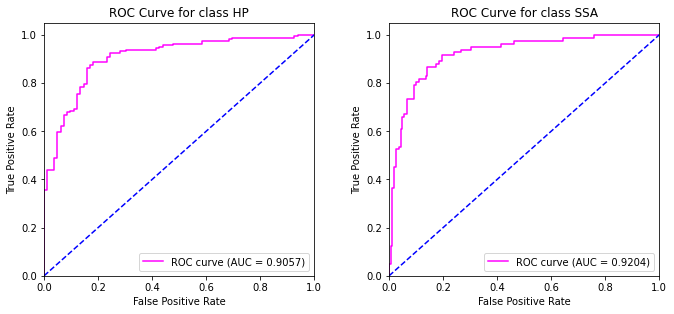

In [ ]:
teacher_model=load_model('task2_teacher_sub.h5')
evaluation(teacher_model,compute_teacher_loss_sub,1e-4)

Precision: 0.819672131147541
Recall: 0.819672131147541
F-1: 0.819672131147541

The AUC of subclass  HP  is 0.8786516853932583
The AUC of subclass  SSA  is 0.8753171438927148


0.819672131147541

<Figure size 432x288 with 0 Axes>

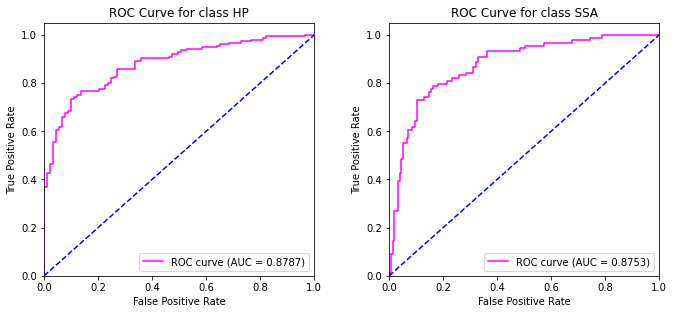

In [ ]:
student_model=load_model('task2_sub_student_kdistill_.h5')
evaluation(student_model,compute_student_loss_sub,1e-3)



-------- with alpha of  0.5 ------------
Precision: 0.8401639344262295
Recall: 0.8401639344262295
F-1: 0.8401639344262295

The AUC of subclass  HP  is 0.9106316314177881
The AUC of subclass  SSA  is 0.9215979491561632
Precision: 0.819672131147541
Recall: 0.819672131147541
F-1: 0.819672131147541

The AUC of subclass  HP  is 0.8980534726955994
The AUC of subclass  SSA  is 0.9192607740665
Precision: 0.7991803278688525
Recall: 0.7991803278688525
F-1: 0.7991803278688525

The AUC of subclass  HP  is 0.8866131756756758
The AUC of subclass  SSA  is 0.8814752252252253
Precision: 0.8155737704918032
Recall: 0.8155737704918032
F-1: 0.8155737704918032

The AUC of subclass  HP  is 0.8946678321678322
The AUC of subclass  SSA  is 0.9057400932400933
Precision: 0.8401639344262295
Recall: 0.8401639344262295
F-1: 0.8401639344262295

The AUC of subclass  HP  is 0.9099941124521636
The AUC of subclass  SSA  is 0.9099941124521638
Precision: 0.8114754098360656
Recall: 0.8114754098360656
F-1: 0.81147540983606

<Figure size 432x288 with 0 Axes>

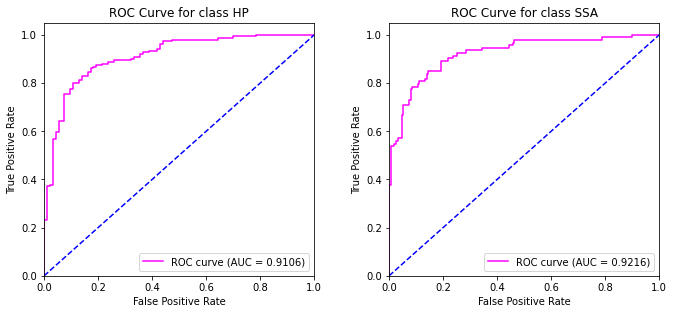

<Figure size 432x288 with 0 Axes>

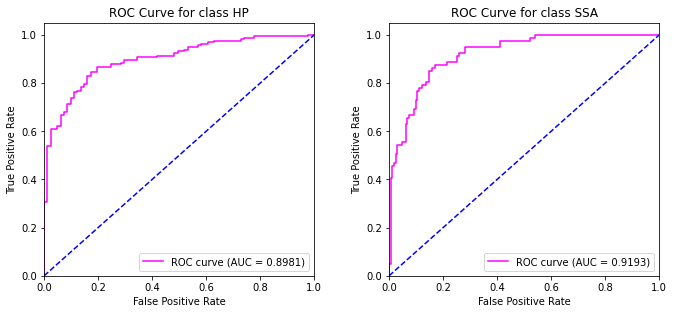

<Figure size 432x288 with 0 Axes>

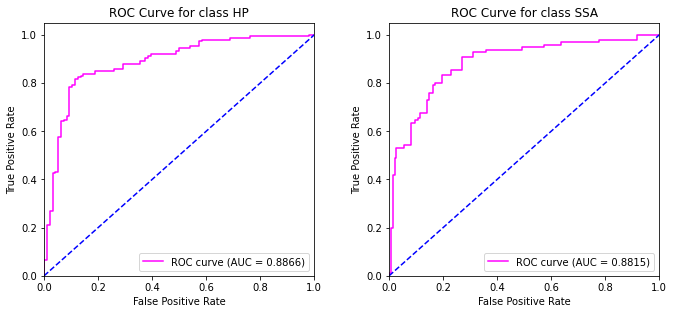

<Figure size 432x288 with 0 Axes>

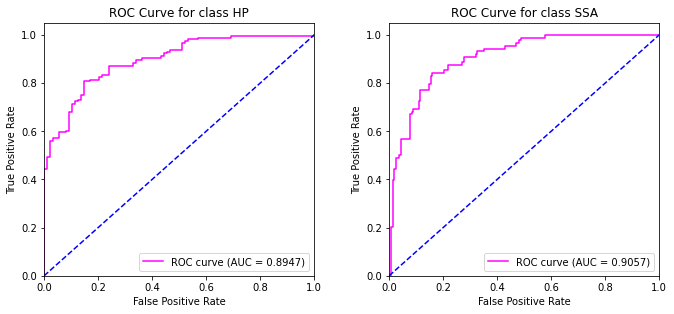

<Figure size 432x288 with 0 Axes>

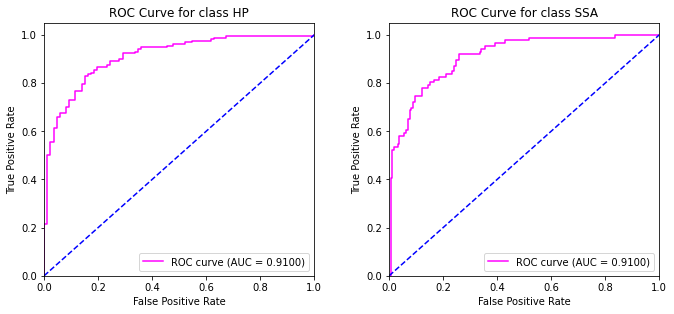

<Figure size 432x288 with 0 Axes>

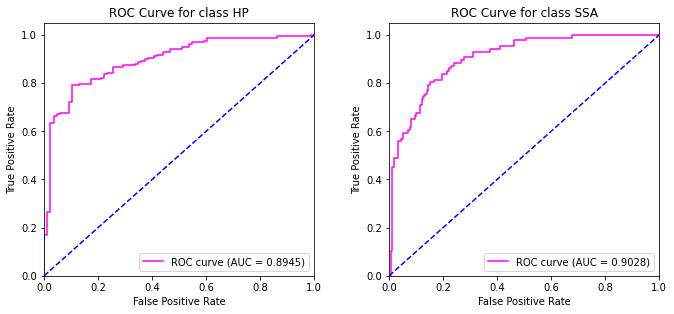

In [ ]:
# temperature
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
_f1_student_sub=[]

# for ALPHA in ALPHA_spectrum:
ALPHA=0.5 
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:  
  # student_with_kd_model = tf.keras.Sequential()
  # student_with_kd_model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(classifier_activation = None, input_shape = (224, 224, 3)))
  # student_with_kd_model.add(tf.keras.layers.Dense(2)) 
  # f1_student_ = train_and_evaluate(student_with_kd_model, compute_student_loss)
  #student_with_kd_model.save("./KD2/student_model_with_kd_sub"+str(DISTILLATION_TEMPERATURE)+'_.h5')
  student_model=load_model("./student_model_with_kd_sub"+str(DISTILLATION_TEMPERATURE)+'_s.h5')
  f1_student_ =evaluation(student_model,compute_student_loss_sub,1e-3)
  _f1_student_sub.append(f1_student_)

In [ ]:
_f1_student_sub

[0.8401639344262295,
 0.819672131147541,
 0.7991803278688525,
 0.8155737704918032,
 0.8401639344262295,
 0.8114754098360656]

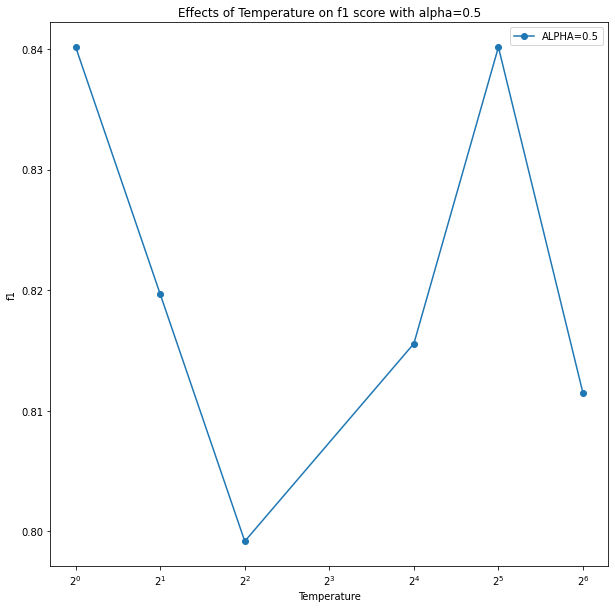

<Figure size 432x288 with 0 Axes>

In [ ]:
# visualization
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale('log',basex=2)
ax.plot(DISTILLATION_TEMPERATURE_spectrum, _f1_student_sub, marker='o', label='ALPHA=0.5')

# plt.ylim(0.75,0.90)
plt.ylabel('f1')
plt.xlabel('Temperature')
plt.title('Effects of Temperature on f1 score with alpha=0.5')
plt.legend()
plt.show()
plt.savefig('task2_temp_f1_sub_task2.png')

In [ ]:
_f1_student=[0.6598360655737705,
              0.6188524590163934,
              0.5983606557377049,
              0.6557377049180327,
              0.680327868852459,
              0.6229508196721312]

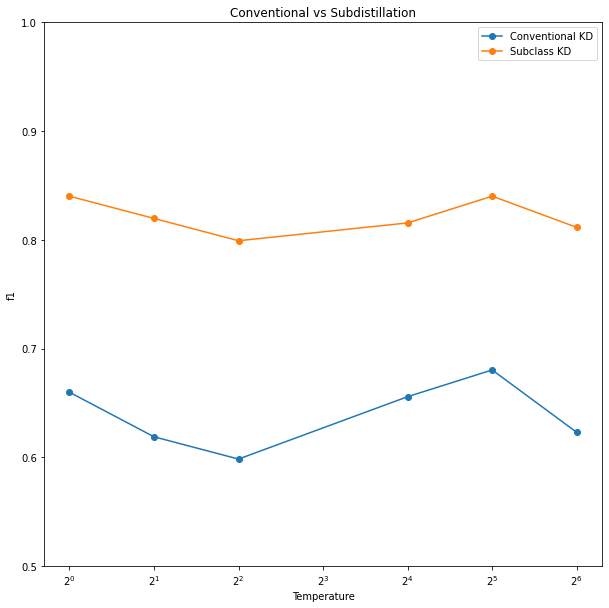

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale('log',basex=2)
ax.plot(DISTILLATION_TEMPERATURE_spectrum, _f1_student, marker='o', label='Conventional KD')
ax.plot(DISTILLATION_TEMPERATURE_spectrum, _f1_student_sub, marker='o', label='Subclass KD')

plt.ylim(0.5,1.)
plt.ylabel('f1')
plt.xlabel('Temperature')
plt.title('Conventional vs Subdistillation')
plt.legend()
plt.show()
plt.savefig('task2_temp_f1_sub_task2.png')